In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import  sum as spark_sum, col,when ,hour, dayofweek, month, to_timestamp,mean, unix_timestamp
import pandas as pd
from pyspark.sql.types import IntegerType, DoubleType, StringType
import joblib
spark = SparkSession.builder.appName('SmartLogi').config("spark.driver.memory", "16g") .config("spark.executor.memory", "16g") .getOrCreate()
df = spark.read.parquet('./data/dataset.parquet')
df.show()

your 131072x1 screen size is bogus. expect trouble
26/01/12 18:43:50 WARN Utils: Your hostname, ELBAHIA resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/12 18:43:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/12 18:43:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [2]:

num_lignes = df.count()


num_colonnes = len(df.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")


Shape du dataset : (3475226, 20)


In [3]:
df.printSchema()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [4]:
df.describe().show()


26/01/12 18:44:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [5]:
df.summary().show()


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [6]:
numeric_cols = [field.name for field in df.schema.fields 
                if isinstance(field.dataType, (IntegerType, DoubleType))]
print("Colonnes numériques :", numeric_cols)


Colonnes numériques : ['VendorID', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee']


In [7]:
categorical_cols = [field.name for field in df.schema.fields 
                    if isinstance(field.dataType, StringType)]
print("Colonnes catégorielles :", categorical_cols)


Colonnes catégorielles : ['store_and_fwd_flag']


In [8]:
from pyspark.sql.functions import col, sum
df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show(truncate=False)

# 2️⃣ Colonnes importantes
important_cols = [
    "passenger_count",
    "RatecodeID",
    "store_and_fwd_flag",
    "congestion_surcharge",
    "Airport_fee"
]

# 3️⃣ Avant nettoyage
print("Avant :", df.count())

# 4️⃣ Suppression ciblée des nulls
df_clean = df.dropna(subset=important_cols)

# 5️⃣ Après nettoyage
print("Après :", df_clean.count())



+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|0       |0                   |0                    |540149         |0            |540149    |540149            |0           |0   

In [9]:
total_rows = df_clean.count()
distinct_rows = df_clean.distinct().count()

num_duplicates = total_rows - distinct_rows
print(f"Nombre de doublons : {num_duplicates}")


Nombre de doublons : 0


In [10]:
# Nombre de lignes
num_lignes = df_clean.count()

# Nombre de colonnes
num_colonnes = len(df_clean.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")

Shape du dataset : (2935077, 20)


In [11]:

df_clean = df_clean.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime")))
df_clean = df_clean.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

df_clean = df_clean.withColumn(
    "trip_duration_min",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/60
)
df_clean.select(
    spark_sum(when(col("trip_duration_min") < 0, 1).otherwise(0)).alias("duration_negative"),
    spark_sum(when(col("trip_duration_min") == 0, 1).otherwise(0)).alias("duration_zero"),
    spark_sum(when(col("trip_duration_min") > 0, 1).otherwise(0)).alias("duration_positive")
).show()


+-----------------+-------------+-----------------+
|duration_negative|duration_zero|duration_positive|
+-----------------+-------------+-----------------+
|                6|         1826|          2933245|
+-----------------+-------------+-----------------+



In [12]:
outliers_trip_distance = df_clean.filter((col("trip_distance") <= 0) | (col("trip_distance") > 200)).count()
outliers_fare = df_clean.filter(col("fare_amount") < 0).count()
outliers_tip = df_clean.filter(col("tip_amount") < 0).count()
outliers_tolls = df_clean.filter(col("tolls_amount") < 0).count()
outliers_total = df_clean.filter(col("total_amount") < 0).count()
outliers_vendor = df_clean.filter((col("VendorID") != 1) & (col("VendorID") != 2)).count()
outliers_ratecode = df_clean.filter(~col("RatecodeID").isin([1,2,3,4,5,6])).count()
outliers_passenger = df_clean.filter(col("passenger_count") <= 0).count()
outliers_duration = df_clean.filter(col("trip_duration_min") <= 0).count()

# Afficher le résultat
print(f"Outliers trip_distance: {outliers_trip_distance}")
print(f"Outliers fare_amount: {outliers_fare}")
print(f"Outliers tip_amount: {outliers_tip}")
print(f"Outliers tolls_amount: {outliers_tolls}")
print(f"Outliers total_amount: {outliers_total}")
print(f"Outliers VendorID: {outliers_vendor}")
print(f"Outliers RatecodeID: {outliers_ratecode}")
print(f"Outliers passenger_count: {outliers_passenger}")
print(f"Outliers trip_duration: {outliers_duration}")

Outliers trip_distance: 38922
Outliers fare_amount: 59296
Outliers tip_amount: 123
Outliers tolls_amount: 4559
Outliers total_amount: 59616
Outliers VendorID: 1206
Outliers RatecodeID: 41963
Outliers passenger_count: 24656
Outliers trip_duration: 1832


In [13]:

df_silver = (
    df_clean
    .filter((col("trip_distance") > 0) & (col("trip_distance") <= 200))
    .filter(col("fare_amount") > 0)
    .filter(col("total_amount") > 0)
    .filter(col("VendorID").isin([1,2]))
    .filter(col("RatecodeID").isin([1,2,3,4,5,6]))
    .filter(col("passenger_count") > 0)
    .filter(col("trip_duration_min") > 0)
    .filter(col("trip_duration_min") < 200)
    .withColumn("tip_amount", when(col("tip_amount") < 0, 0).otherwise(col("tip_amount")))
    .withColumn("tolls_amount", when(col("tolls_amount") < 0, 0).otherwise(col("tolls_amount")))
)


In [14]:
# Nombre de lignes
num_lignes = df_silver.count()

# Nombre de colonnes
num_colonnes = len(df_silver.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")

Shape du dataset : (2775338, 21)


In [15]:
# Time-based features
df_silver = df_silver.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
df_silver = df_silver.withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime")))
df_silver = df_silver.withColumn("pickup_month", month(col("tpep_pickup_datetime")))


df_silver.show(15)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+----------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee| trip_duration_min|pickup_hour|pickup_dayofweek|pickup_month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+---------

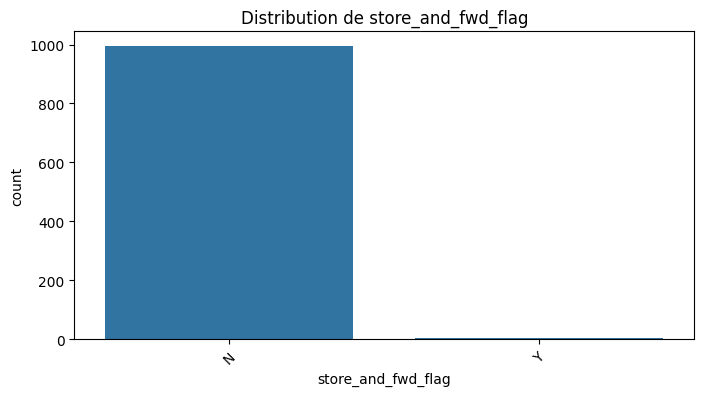

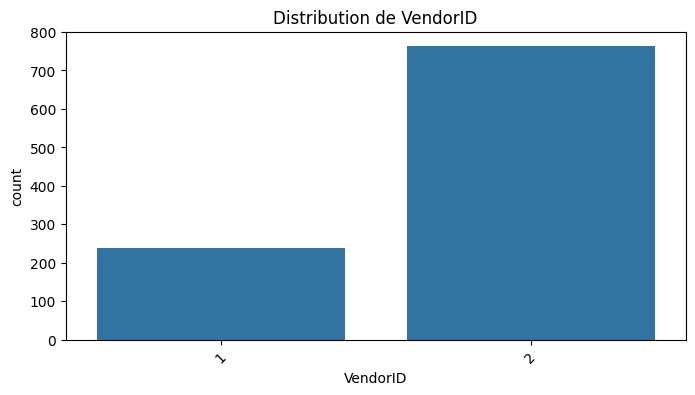

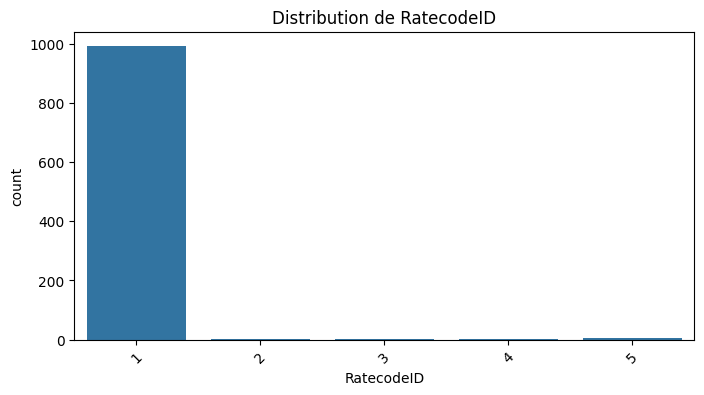

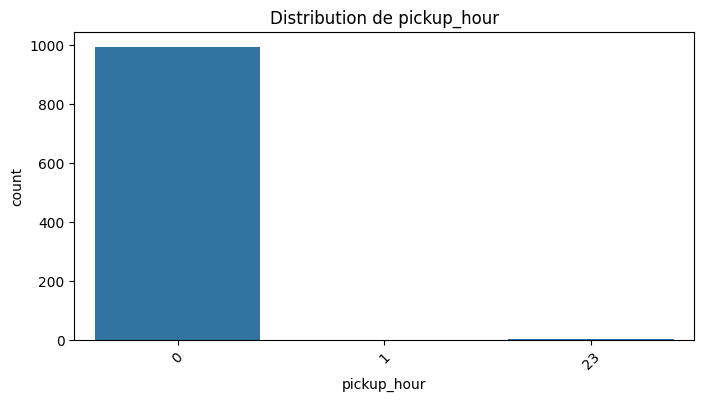

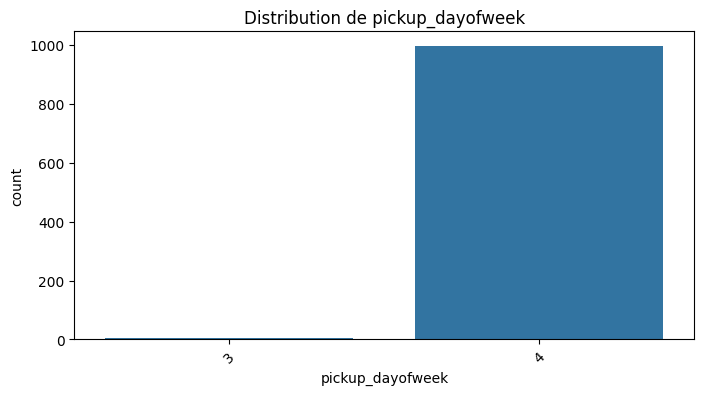

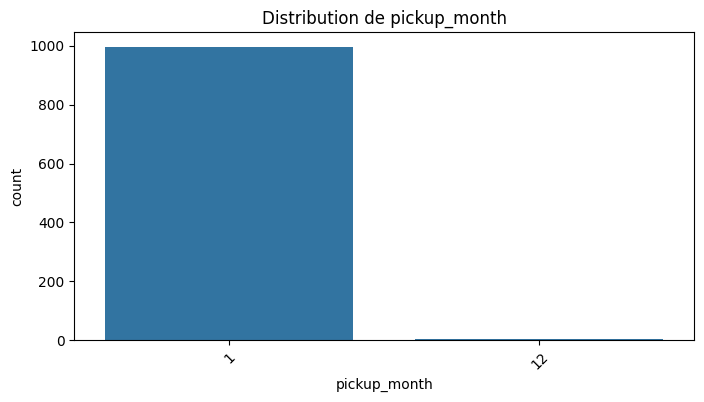

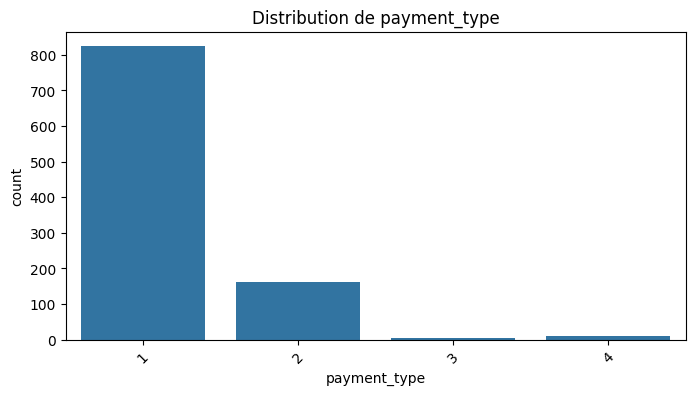

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
categorical_cols=["store_and_fwd_flag","VendorID","RatecodeID","pickup_hour","pickup_dayofweek","pickup_month","payment_type"]

for c in categorical_cols:
    col_index = c + "_index"
    
    pdf = df_silver.select(c).limit(1000).toPandas()
    
    plt.figure(figsize=(8,4))
    sns.countplot(x=c, data=pdf)
    plt.title(f"Distribution de {c}")
    plt.xticks(rotation=45)
    plt.show()

In [17]:
corr_features = [
    "trip_duration_min",
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
    "cbd_congestion_fee",
    "passenger_count",
   
    "PULocationID",
    "DOLocationID"
]



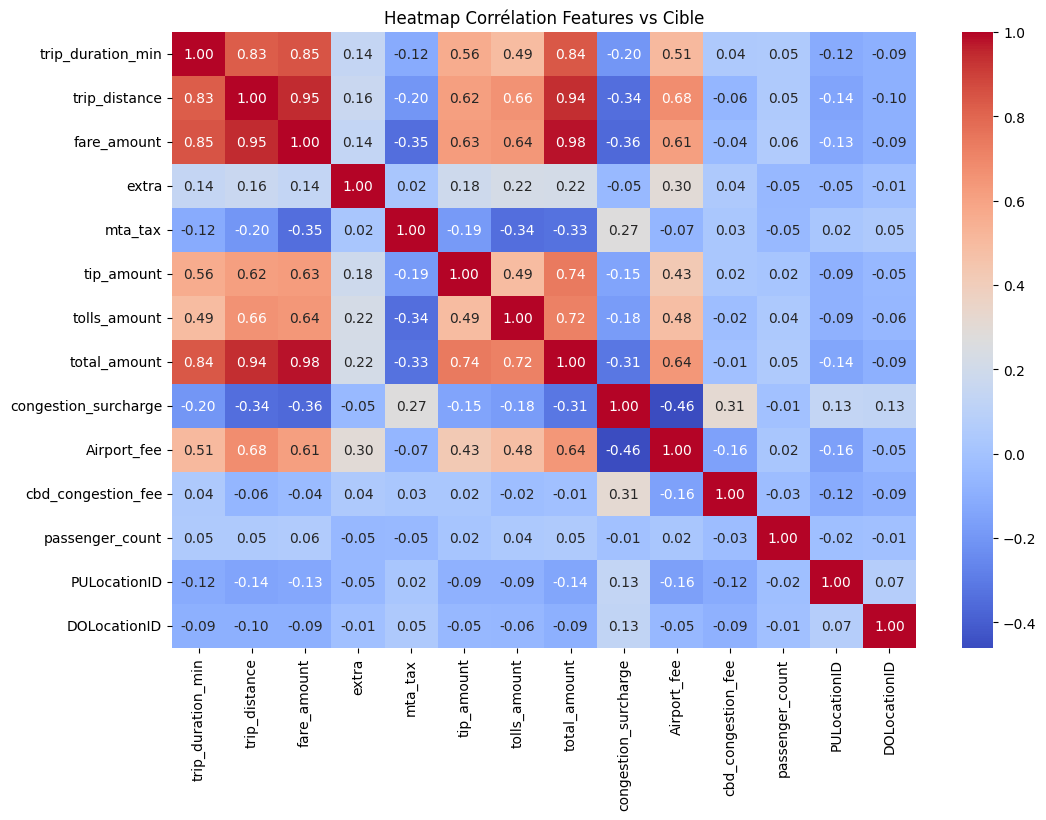

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df_silver.select(corr_features).sample(0.1).toPandas()
# Corrélation
corr_matrix = pdf.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap Corrélation Features vs Cible")
plt.show()


In [19]:
# from pyspark.sql.types import StringType
# categorical_cols=["store_and_fwd_flag","VendorID","RatecodeID","pickup_hour","pickup_dayofweek","pickup_month","payment_type"]
# for c in categorical_cols:
#     if not isinstance(df_silver.schema[c].dataType, StringType):
#         df_silver = df_silver.withColumn(c, col(c).cast("string"))

In [20]:
# from pyspark.ml.feature import StringIndexer, OneHotEncoder
# from pyspark.ml import Pipeline
# # 
# # Indexer
# indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in categorical_cols]

# # OneHotEncoder
# indexed_cols = [c+"_index" for c in categorical_cols]
# ohe_cols = [c+"_ohe" for c in categorical_cols]
# encoder = OneHotEncoder(inputCols=indexed_cols, outputCols=ohe_cols)

# # Pipeline
# pipeline = Pipeline(stages=indexers + [encoder])
# df_encoded = pipeline.fit(df_silver).transform(df_silver)

# df_encoded.select(indexed_cols + ohe_cols).show(5, truncate=False)


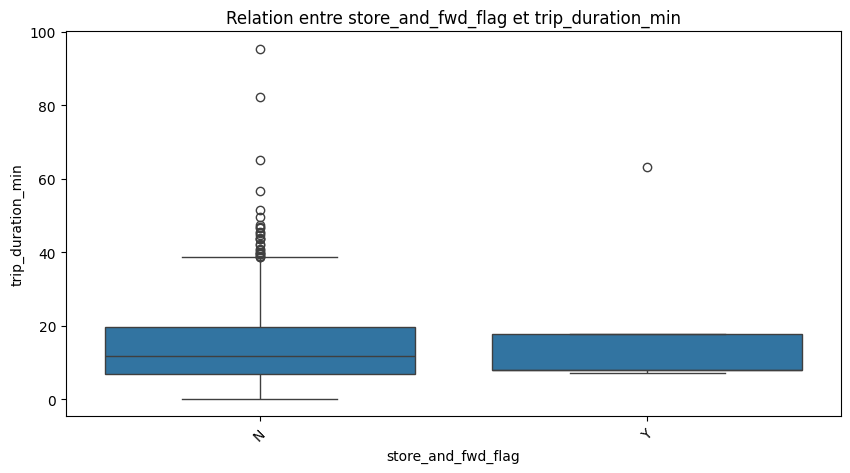

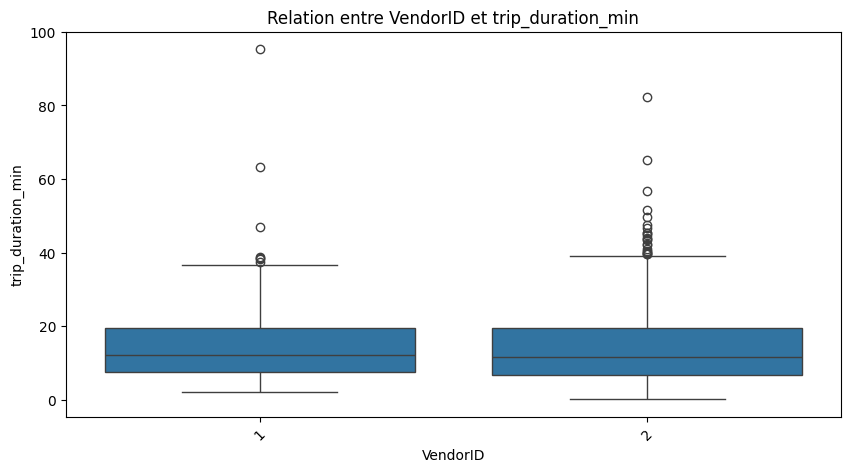

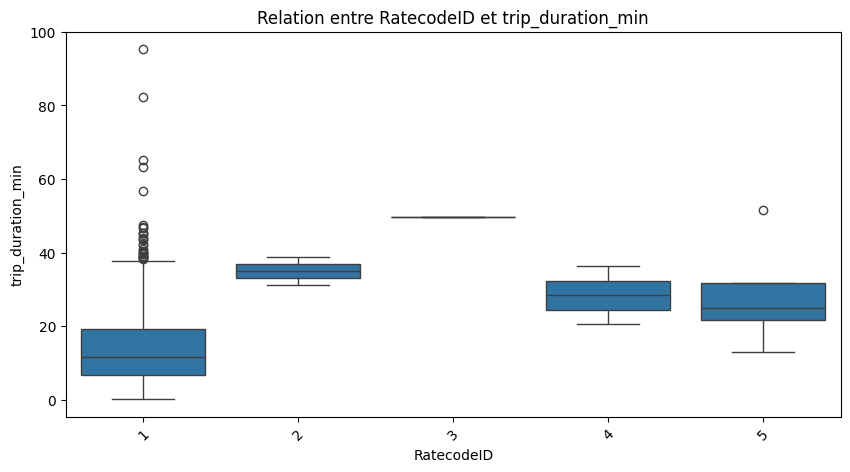

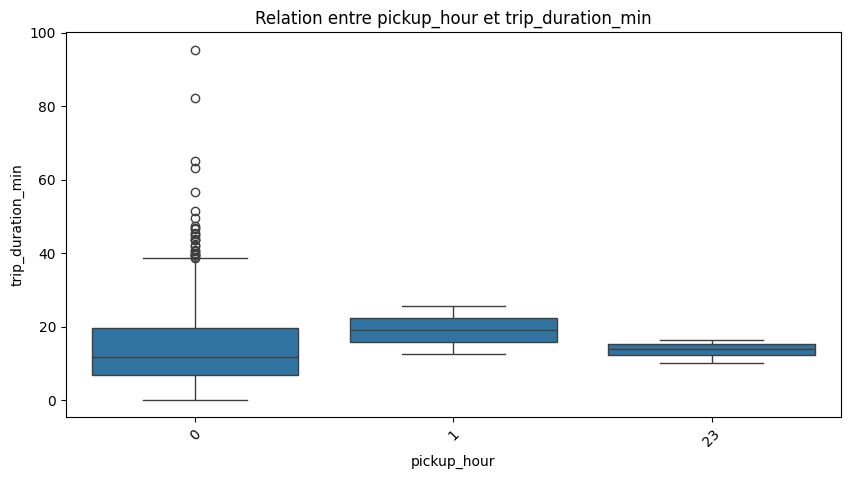

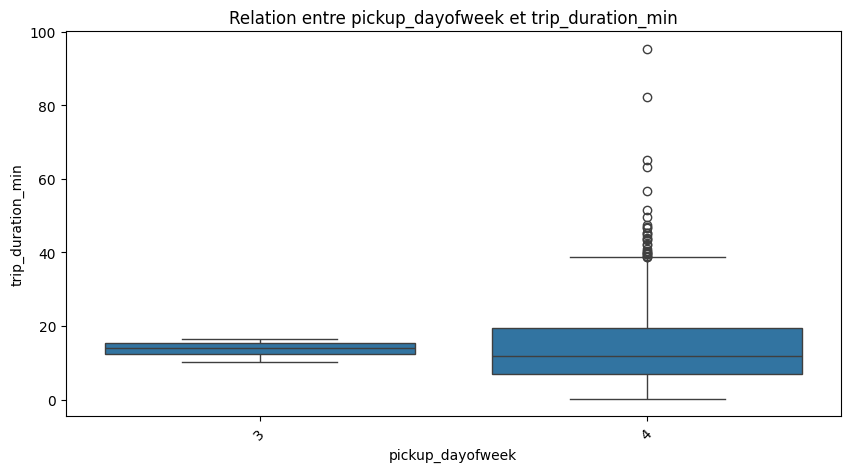

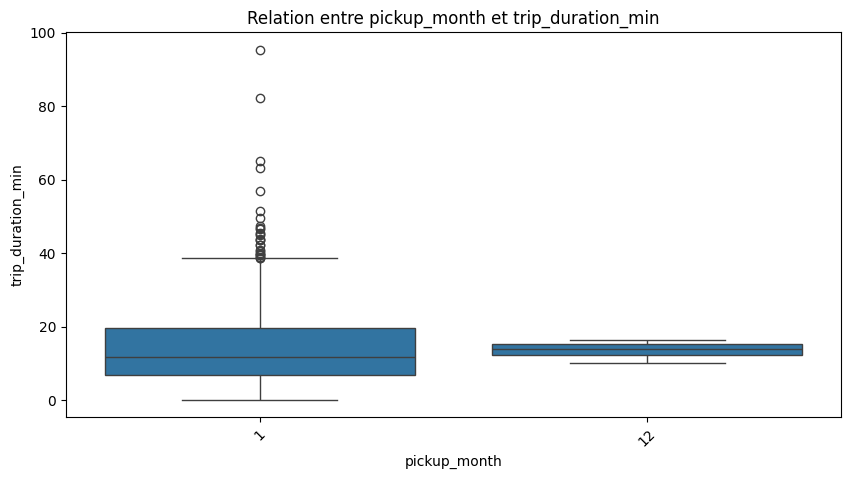

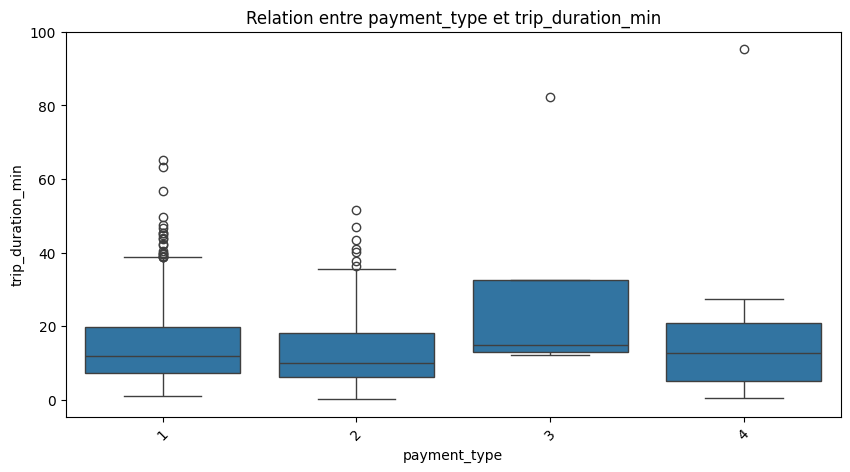

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

target_col = "trip_duration_min"  

for c in categorical_cols:
      
    
    pdf = df_silver.select(c, target_col).limit(1000).toPandas()
    
    plt.figure(figsize=(10,5))
    sns.boxplot(x=c, y=target_col, data=pdf)
    plt.title(f"Relation entre {c} et {target_col}")
    plt.xticks(rotation=45)
    plt.show()


In [25]:
df_silver.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'cbd_congestion_fee',
 'trip_duration_min',
 'pickup_hour',
 'pickup_dayofweek',
 'pickup_month']

In [26]:


columns_keep = [
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "total_amount",
    "Airport_fee",
    "trip_duration_min",
    "payment_type",
    "RatecodeID",
    "pickup_hour",
 "pickup_dayofweek",
 "pickup_month"
]



df_silver = df_silver.select(columns_keep)


In [27]:
# Nombre de lignes
num_lignes = df_silver.count()

# Nombre de colonnes
num_colonnes = len(df_silver.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")


Shape du dataset : (2775338, 12)


In [28]:

# df_silver_single = df_silver.coalesce(1)

df_silver.coalesce(1).write.mode("overwrite").parquet("./data/silver/silver_dataset_single")


In [29]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LoadSilverToPostgres") \
    .getOrCreate()

df_silver_single = spark.read.parquet("./data/silver/silver_dataset_single")

df_silver_single.printSchema()
print("Nombre de lignes :", df_silver_single.count())


26/01/12 18:53:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_dayofweek: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)

Nombre de lignes : 2775338


In [34]:
from pyspark.ml.feature import VectorAssembler

columns_to_use = [
     "trip_distance",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "total_amount",
    "Airport_fee",
    "RatecodeID",
    "pickup_hour",
 "pickup_dayofweek"

]

assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")

df_model = assembler.transform(df_silver_single).select("features", "trip_duration_min")



In [35]:

from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.regression import LinearRegression
# # Split data
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)


# lr = LinearRegression(featuresCol="features", labelCol="trip_duration_min")
# lr_model = lr.fit(train_data)


# predictions = lr_model.transform(test_data)



# evaluator = RegressionEvaluator(
#     labelCol="trip_duration_min",
#     predictionCol="prediction",
#     metricName="mae"
# )
# mae = evaluator.evaluate(predictions)
# print(f"mae du modèle Linear Regression : {mae}")

# evaluator_r2=RegressionEvaluator(
#   labelCol="trip_duration_min",
#   predictionCol="prediction",
#   metricName="r2"
#  )
# r2=evaluator_r2.evaluate(predictions)
# print(f"r2 de model Linear Regression:{r2}")

# evaluator_rmse = RegressionEvaluator(
#     labelCol="trip_duration_min",
#     predictionCol="prediction",
#     metricName="rmse"
# )
# rmse=evaluator_rmse.evaluate(predictions)
# print(f"rmse de model  Linear Regression : {rmse}")

In [36]:
from pyspark.ml.regression import RandomForestRegressor 
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="trip_duration_min",
    predictionCol="rf_prediction",
    numTrees=50,
    maxDepth=7,
    seed=42
)

rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)

for metric in ["rmse", "mae", "r2"]:
    score = RegressionEvaluator(
        labelCol="trip_duration_min",
        predictionCol="rf_prediction",
        metricName=metric
    ).evaluate(rf_preds)
    print(f"{metric.upper()} du Random Forest : {score}")


26/01/12 19:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1038.0 KiB


RMSE du Random Forest : 3.7402427954262367


MAE du Random Forest : 1.8916939808393374


R2 du Random Forest : 0.8797558165296181


In [ ]:
# rf_model.write().overwrite().save("./models/rf_trip_duration_model")
# print("Modèle Random Forest sauvegardé dans ./models/rf_trip_duration_model")

In [37]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="trip_duration_min",
    predictionCol="gbt_prediction",
    maxIter=50,
    maxDepth=5,
    seed=42
)

gbt_model = gbt.fit(train_data)
gbt_preds = gbt_model.transform(test_data)

gbt_preds.select("trip_duration_min", "gbt_prediction").show(5)


for metric in ["rmse", "mae", "r2"]:
    score = RegressionEvaluator(
        labelCol="trip_duration_min",
        predictionCol="gbt_prediction",
        metricName=metric
    ).evaluate(gbt_preds)

    print(f"{metric.upper()} du GBT : {score}")









+-------------------+-------------------+
|  trip_duration_min|     gbt_prediction|
+-------------------+-------------------+
|0.13333333333333333|-3.6758435749312284|
|                0.4|  2.044081916429194|
|0.11666666666666667| 2.0545660588641836|
|               0.15| 2.0545660588641836|
|                0.7| 2.0545660588641836|
+-------------------+-------------------+
only showing top 5 rows



RMSE du GBT : 3.117391116667494


MAE du GBT : 1.4639640334811828


R2 du GBT : 0.9164691165888319


In [38]:
gbt_model.save("models/pyspark_model")